### Introduction

By the year 2912, interstellar voyages have become a commonplace component of human civilization, presenting unique challenges and opportunities for the field of advanced data science. It was against this backdrop that a critical situation emerged involving the Spaceship Titanic, a pioneering interstellar passenger vessel. Launched just a month prior, this vessel was transporting approximately 13,000 individuals to start anew on one of three terraformed exoplanets within the neighboring stellar systems.

Unfortunately, the journey was marred by a catastrophic event as the vessel neared Alpha Centauri, heading towards the temperate exoplanet 55 Cancri E. The Spaceship Titanic encountered an undetected spacetime anomaly hidden within an interstellar dust cloud. Echoing the tragic fate of its namesake from a millennium ago, the vessel remained structurally intact, yet a significant portion of its passengers were instantaneously transported to an alternate dimension [1].

### The Challenge

To analyze the datasets recovered from the ship's compromised data systems to ascertain which passengers were affected by the anomaly and thus displaced from their original dimension. The successful identification of these individuals is imperative for the coordination of a rescue operation and holds the potential to prevent a disaster of historical magnitude.
The goal is to unlock the solution to this cosmic enigma, offering relief and hope to the myriad lives in anticipation of news regarding their displaced kin.


#### Reference
https://www.kaggle.com/competitions/spaceship-titanic/overview

In [11]:
# Begin by importing all required libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn import datasets
import seaborn as sns


# Define plot settings
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["figure.figsize"] = (20,10)

### Dataset explanation

- **`PassengerId`**: A unique Id for each passenger, formatted as ***gggg_pp*** where ***gggg*** indicates a group the passenger is traveling with, and ***pp*** is their number within the group. People in a group are often family members, but not always.

- **`HomePlanet`**: The planet the passenger departed from, typically their planet of permanent residence.

- **`CryoSleep`**: Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

- **`Cabin`**: The cabin number where the passenger is staying, formatted as ***deck/num/side***, where ***side*** can be either ***P*** for Port or ***S*** for Starboard.

- **`Destination`**: The planet the passenger will be debarking to.

- **`Age`**: The age of the passenger.

- **`VIP`**: Whether the passenger has paid for special VIP service during the voyage.

- **`RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`**: The amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

- **`Name`**: The first and last names of the passenger.

- **`Transported`**: Whether the passenger was transported to another dimension. This is the target column for prediction.


## 1. Data Analysis
### First, identify missing values in the data

In [12]:
# Read data
train_df = pd.read_csv('csv_files/train.csv')

# Preview data
print('Raw data format:')
display(train_df.head())

# Determining the amount of missing data per column
missing_data = train_df.isna().sum()

# Calculating the percentage of missing data per column
missing_percentage = (missing_data / len(train_df)) * 100

missing_info = pd.DataFrame({
    "Missing Values": missing_data,
    "Percentage": missing_percentage
})

missing_info.sort_values(by="Missing Values", ascending=False)

Raw data format:


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


,Missing Values,Percentage
CryoSleep,217,2.496261
ShoppingMall,208,2.392730
VIP,203,2.335212
HomePlanet,201,2.312205
Name,200,2.300702
Cabin,199,2.289198
VRDeck,188,2.162660
FoodCourt,183,2.105142
Spa,183,2.105142
Destination,182,2.093639


`PassengerId` and `Transported` have no missing values. The missingness pattern suggests that the data might be Missing Completely at Random (MCAR) or Missing at Random (MAR), as the percentages are relatively low and distributed across various features without an apparent pattern. However, further analysis would be required to ascertain the missingness mechanism fully, especially considering the potential relationships between features (e.g., passengers from a specific HomePlanet might have more missing data in certain amenities due to cultural preferences or socioeconomic factors). Subsequent sections on data analysis aim to identify potential relationships between features.
>Reference : Mack C, Su Z, Westreich D. Managing Missing Data in Patient Registries: Addendum to Registries for Evaluating Patient Outcomes: A User’s Guide, Third Edition [Internet]. Rockville (MD): Agency for Healthcare Research and Quality (US); 2018 Feb. Types of Missing Data. Available from: https://www.ncbi.nlm.nih.gov/books/NBK493614/

## 1.1 Target Variable Analysis 

In [38]:
# Since 'Transported' is bool, just use direct sum
transported_true_percentage = (train_df['Transported'].sum() / len(train_df['Transported'])) * 100

transported_false_percentage = 100 - transported_true_percentage

print('Percentage of travellers transported: {:.2f}%'.format(transported_true_percentage))
print('Percentage of travellers NOT transported: {:.2f}%'.format(transported_false_percentage))

Percentage of travellers transported: 50.36%
Percentage of travellers NOT transported: 49.64%


**Inference:**
> The distribution of the target variable is approximately equal, showing that about half of the people on the ship were mysteriously transported. This shows us that the data is indeed balanced, so accuracy is a good metric.

## 1.2 Visualisation of Continous Features 
Having an idea of the distribution of the continous features in the dataframe will give us an idea of the skew present in the data.

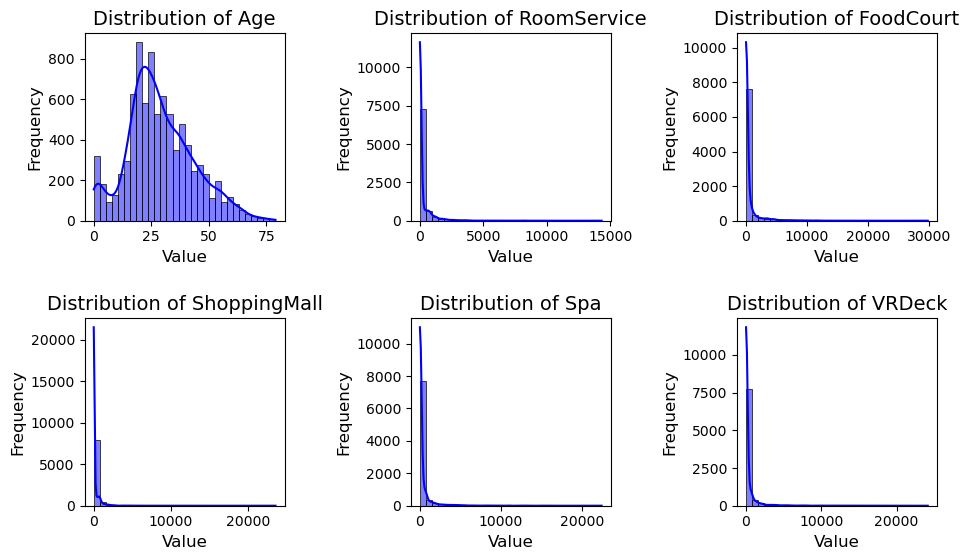

In [24]:
# Identify continuous columns
cont_cols = [f for f in train_df.columns if train_df[f].dtype in [np.float64, np.int64] and train_df[f].nunique() > 20]

# Calculate the number of rows needed for the subplots
n_rows = np.ceil(len(cont_cols) / 3).astype(int)

# Create subplots with 3 columns and the necessary number of rows
fig, axs = plt.subplots(n_rows, 3, figsize=(10, 3 * n_rows))

# Flatten the axs array for easy iteration
axs = axs.flatten()

for i, col in enumerate(cont_cols):
    sns.histplot(train_df[col], ax=axs[i], kde=True, color='blue', bins=30)
    axs[i].set_title(f'Distribution of {col}', fontsize=14)
    axs[i].set_xlabel('Value', fontsize=12)
    axs[i].set_ylabel('Frequency', fontsize=12)
    axs[i].tick_params(axis='both', which='major', labelsize=10)


plt.tight_layout()
plt.show()

>From the above distributions we see that all the features are heavily skewed to the right, with only the age being slighly less skewed, with most of the people on board in the age range of 20-30 years old.

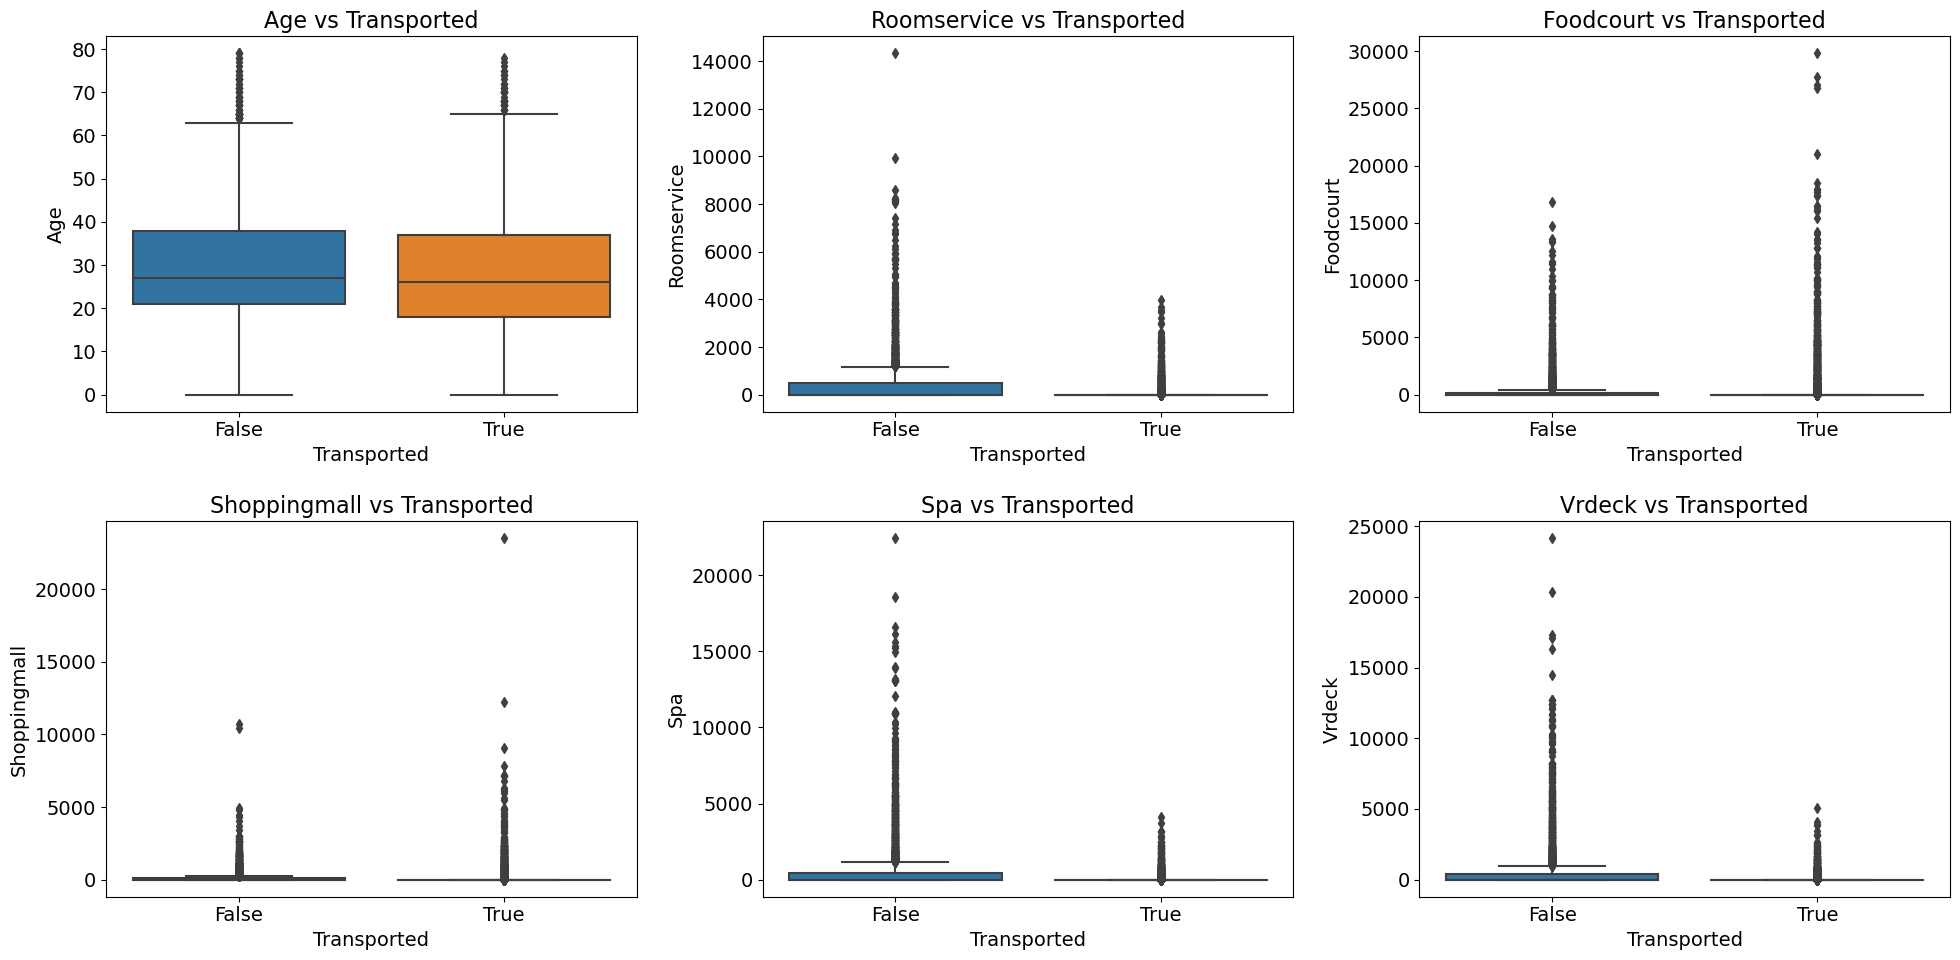

In [22]:
# Create subplots with 3 columns per row
fig, axs = plt.subplots(n_rows, 3, figsize=(20, 5 * n_rows))

# Flatten the axs array for easy iteration
axs = axs.flatten()

for i, col in enumerate(cont_cols):
    sns.boxplot(x='Transported', y=col, data=train_df, ax=axs[i])
    axs[i].set_title(f'{col.title()} vs Transported', fontsize=16)
    axs[i].set_xlabel('Transported', fontsize=14)
    axs[i].set_ylabel(col.title(), fontsize=14)
    axs[i].tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.show()

#### Insights From the Box Plots :

1. **Age vs Transported**: The distribution of ages is relatively similar for both transported and not transported passengers. This indicates that age may not be a strong differentiator in predicting whether a passenger was transported or not.

2. **Roomservice vs Transported**: For the 'Roomservice' expenditure, there's a noticeable trend where passengers who were not transported have more outliers on the higher end of spending, which suggests that passengers who spent more on room service were less likely to be transported.

3. **Foodcourt vs Transported**: A similar trend is observed with the 'Foodcourt' spending as with 'Roomservice',except with an inverse correlation. Those who were transported have more outliers on the extreme end of spending. From a practical perspective (although the data is inherently fictious), this suggests that those who spent more on roomservice probably spent less in the food court - indicating that these two features may be linked. 

4. **Shoppingmall vs Transported**: 'Shoppingmall' spending shows a similar distribution across both categories, with not many outliers and the medians close to zero, however there are more outliers with 'true' compared to false.

5. **Spa vs Transported**: Expenditure on the spa seems to follow the same pattern as 'Roomservice'  where passengers who were not transported show a trend of higher spending, as evidenced by more significant outliers.

6. **VR Deck vs Transported**: Spending on the VR Deck is again similar to the pattern observed in 'Roomservice',  and 'Spa', with those not transported showing higher spending.

#### Implications of the distributions

1. **Outliers** There are significant outliers in the expenditure categories, neccesitating a careful approach to dealing with these features as the outliers may decrease the performance of the machine learning algorithm. 
2. **Feature Importance** Not all features appear to have a strong correlation with being transported or not, for example age seems not to be a factor that plays a role. 
3. **Feature Engineering** Features which have similar distributions such as the expenditure related features, could be grouped together to represent the overall spending habits of an individual. 



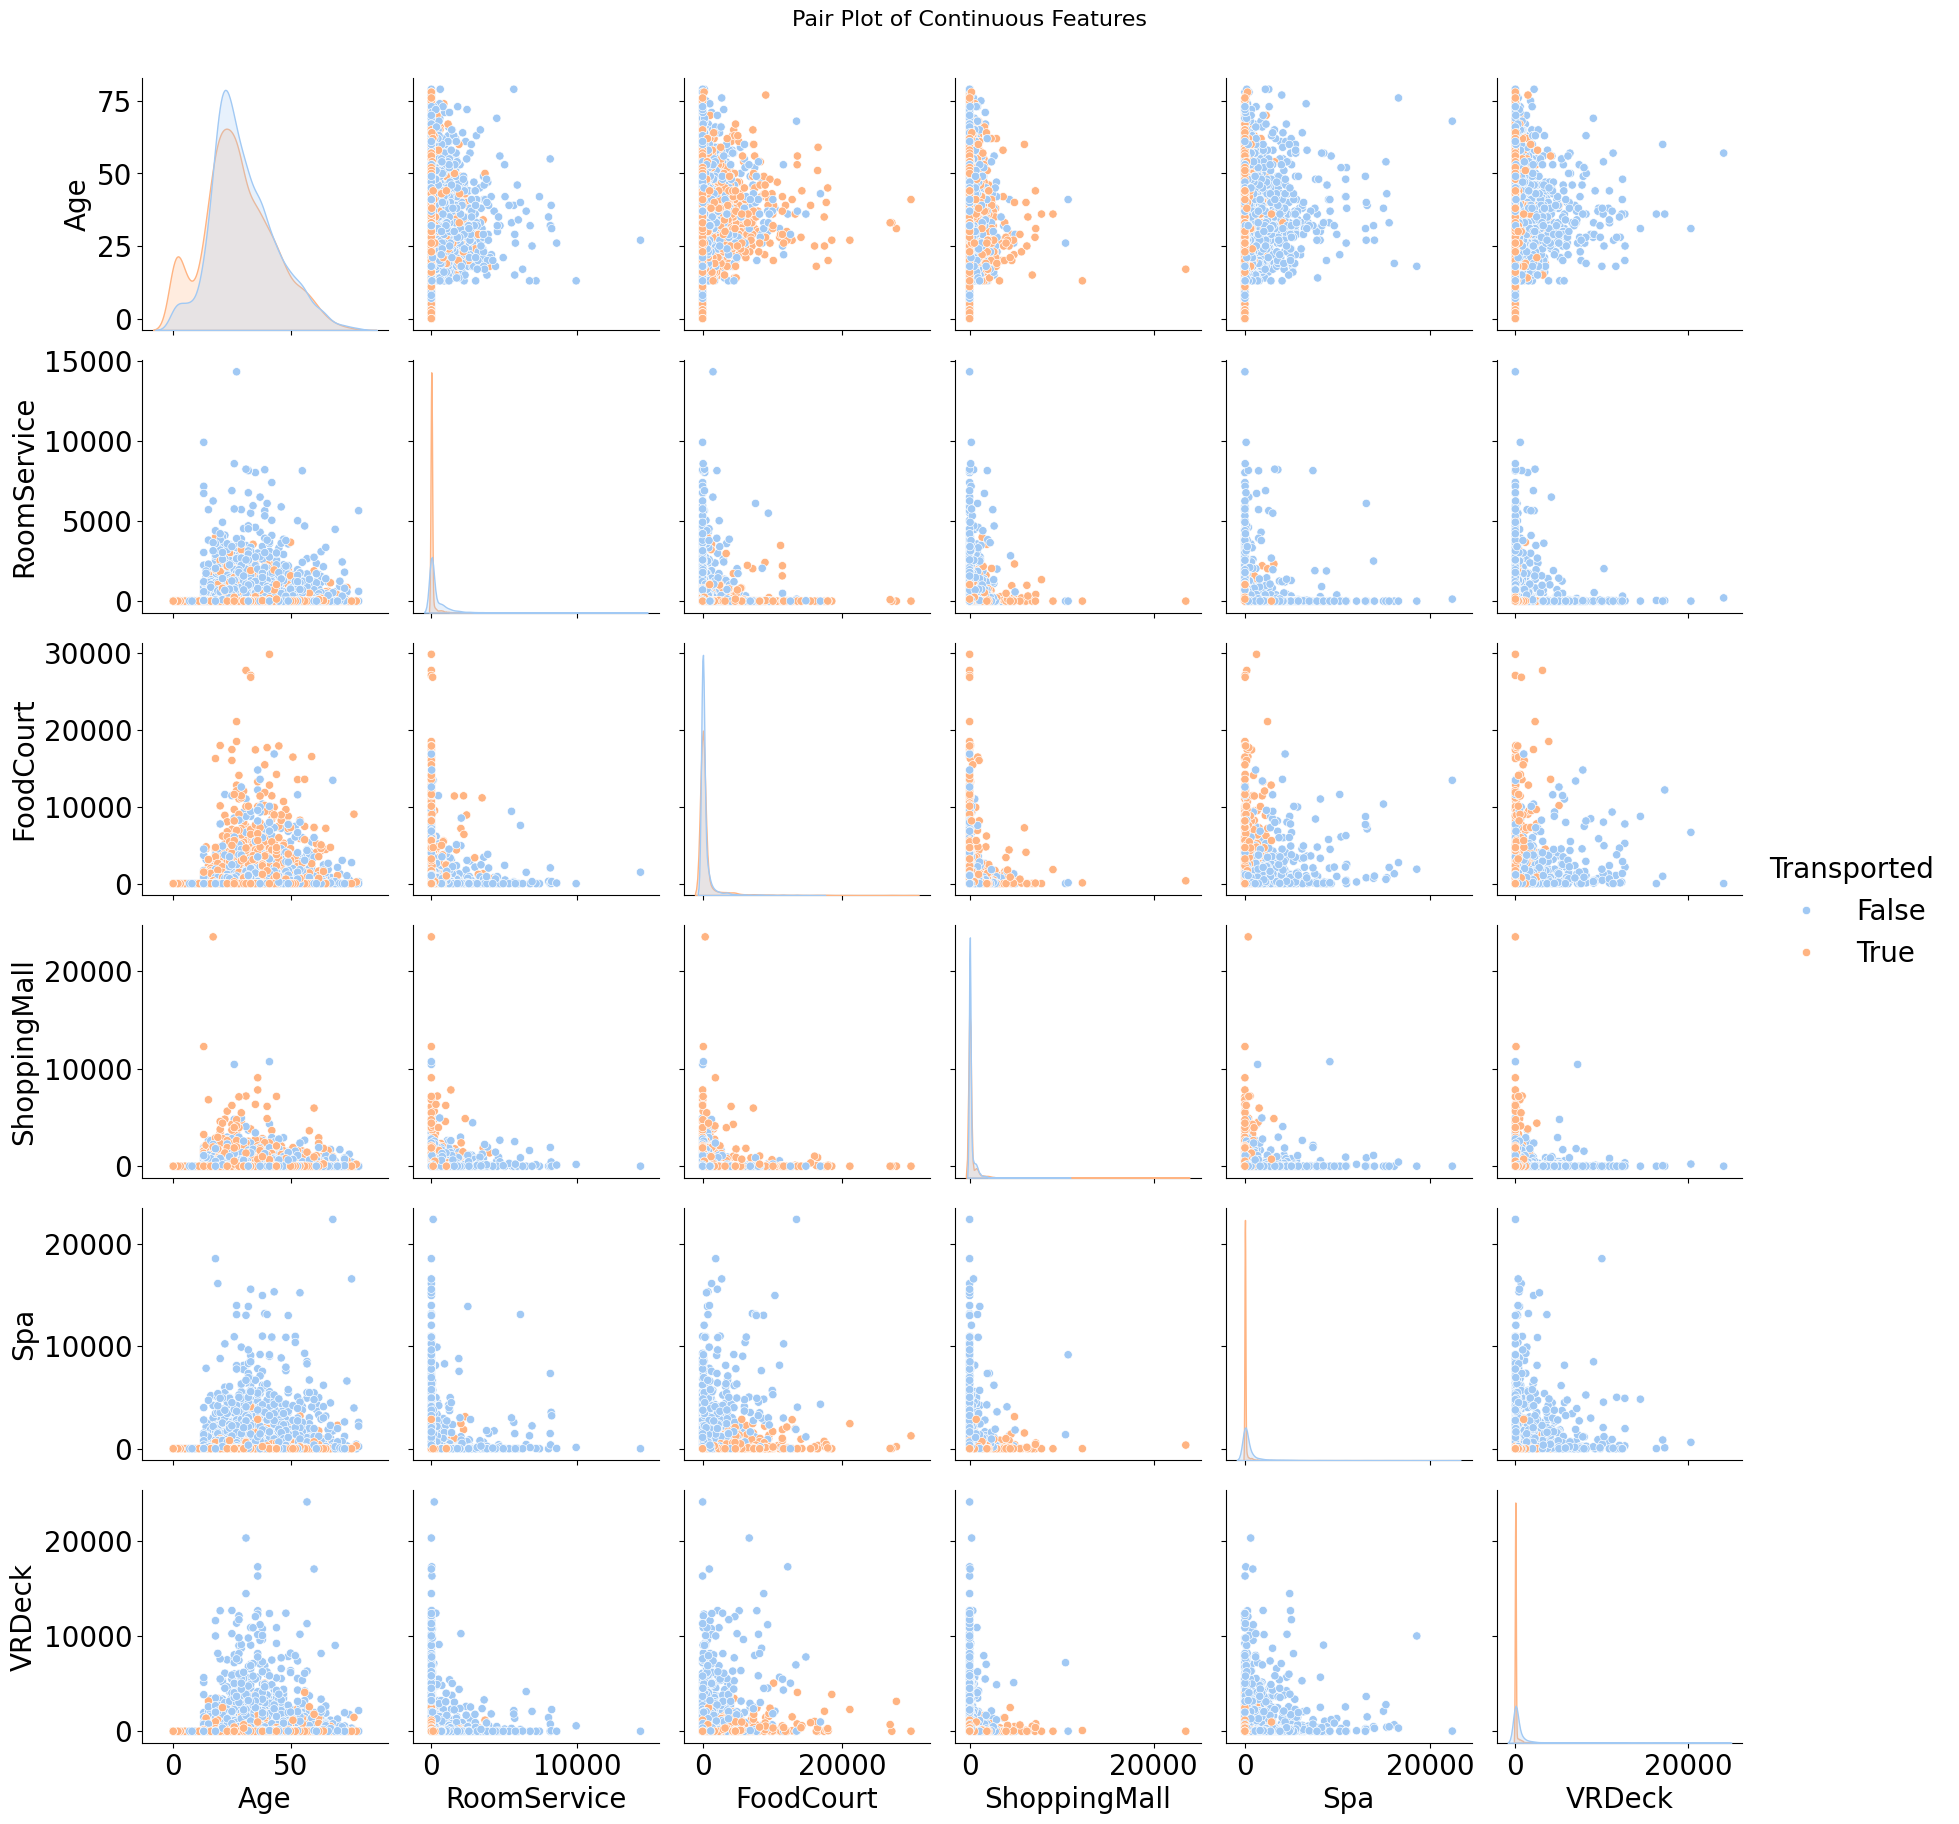

In [ ]:
sns.pairplot(data=train_df, vars=cont_cols, hue='Transported', palette='pastel', height=3)
plt.suptitle('Pair Plot of Continuous Features', size=16, y=1.02)
plt.show()


#### Insights From the Pairwise Plots

1. **Diagonal (Distribution of Each Variable)**: 
   - Age: The distribution of age is fairly normal but with a slight right skew.
   - RoomService, FoodCourt, ShoppingMall, Spa, VRDeck: All these features have distributions that are heavily right-skewed, indicating that a majority of passengers spend little to no money on these services, with a few spending a lot.

2. **Non-Diagonal (Relationship Between Variables)**:
   - There do not appear to be strong linear relationships between any two given features; this is characterized by the lack of discernible trends or patterns in the scatter plots.
   - Most scatter plots exhibit clustering at the lower end of the expenditure features, suggesting that the majority of data points have low spending values across these services.
   - The points are colored by whether the individual was transported or not, but there does not seem to be a clear separation between the two classes based on these features alone, implying that a simple linear model might struggle to distinguish between the classes based on these features alone.
   - There are several outliers, particularly in the expenditure features, which could be influential points for certain types of models. These might need to be examined further to determine if they should be kept, scaled, or handled in another manner.


## 1.3 Strategies for Missing Values 

1. **Age**: Given its distribution and lack of strong differentiation power for the target variable, imputing missing values with the median age might be a prudent choice to maintain the distribution's shape.

2. **Expenditure Features (RoomService, FoodCourt, ShoppingMall, Spa, VRDeck)**: These features exhibit right-skewness and contain significant outliers, suggesting that imputation methods that preserve these characteristics, such as median imputation or even more sophisticated methods like KNN or iterative imputation, might be appropriate. Considering the presence of outliers, median imputation could be more robust than mean imputation.

3. **Categorical Features (HomePlanet, CryoSleep, Destination, VIP)**: For missing categorical data, mode imputation (replacing missing values with the most frequent category) could be a straightforward and effective approach.

4. **Outliers and Feature Engineering**: Given the insights on outliers and spending habits, we might consider creating new features that summarize overall spending or capture spending behavior patterns. Additionally, treating or capping outliers before model training could improve model robustness.

5. **Missing Flags**: For features with a significant amount of missing data, consider creating binary "missing flag" features that indicate whether a data point was originally missing. This can sometimes capture additional information that the missingness itself provides.

**ADD EXPLANATION OF CODE BELOW**

In [ ]:
from sklearn.impute import SimpleImputer
# Imputers
median_imputer = SimpleImputer(strategy='median')
mode_imputer = SimpleImputer(strategy='most_frequent')

# List of numerical and categorical columns that need imputation
numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Imputation
train_df[numerical_cols] = median_imputer.fit_transform(train_df[numerical_cols])
train_df[categorical_cols] = mode_imputer.fit_transform(train_df[categorical_cols])

# Verify the imputation by checking for missing values again
missing_data_after = train_df.isna().sum()

missing_data_after


PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin           199
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            200
Transported       0
dtype: int64